In [1]:
import scipy.stats as stats
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import random
import sys
import pymc3 as pm
import arviz as az
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import pandas as pd
import theano.tensor as tt

np.random.seed(1234)

In [2]:
# The aim of this practical is to construct and constrain a Bayesian hierarchical model for the 
# distribution of masses of black holes, based on LIGO O1 and O2 observations. To describe the 
# gravitational wave measurements we will use the posterior distribution on the chirp mass and
# symmetric mass ratio. The median and 90% symmetric credible intervals for the events in the 
# GWTC-1 paper were as follows. Entries are written in the form 
#      GWXXX: [Mc_low, Mc_med, Mc_high]   [eta_low, eta_med, eta_high]
# where Mc_low, Mc_med and Mc_high are, respectively, the lower edge of the 90% credible interval, 
# the median and the upper edge of the 90% credible interval for the chirp mass, and eta_low, 
# eta_med, eta_high are the corresponding quantities for the symmetric mass ratio.

# GW150914: [27.1, 28.6, 30.3] [0.2397, 0.2487, 0.2500] 
# GW151012: [14.0, 15.2, 17.3] [0.1547, 0.2334, 0.2498] 
# GW151226: [8.6, 8.9, 9.2] [0.1514, 0.2301, 0.2498] 
# GW170104: [19.6, 21.4, 23.6] [0.2082, 0.2386, 0.2498] 
# GW170608: [7.7, 7.9, 8.1] [0.1870, 0.2417, 0.2499] 
# GW170729: [30.6, 35.4, 41.9] [0.2030, 0.2408, 0.2499]
# GW170809: [23.2, 24.9, 27.0] [0.2122, 0.2409, 0.2499] 
# GW170814: [23.0, 24.1, 25.5] [0.2339, 0.2478, 0.2500] 
# GW170818: [24.8, 26.5, 28.6] [0.2241, 0.2453, 0.2499] 
# GW170823: [25.6, 29.2, 33.8] [0.2130, 0.2446, 0.2499] 

# To aid computation we will approximate these posterior distributions. The chirp mass posteriors 
# will be approximated by a Gaussian, with mean equal to Mc_med and standard deviation equal to 
# (Mc_high-Mc_low)/3.29. For the symmetric mass ratio posteriors, we will use a B(a,1) distribution
# approximation for 4*eta. As can be seen from the Table above, the eta posteriors are not Gaussian, 
# but peak at the upper end of the allowed range, near eta = 0.25. A Beta(a,1) distribution has a 
# similar form, on the interval [0,1], which is why we represent the distribution in this way. For
# B(a,1), the median value satisfies x^a = 0.5 and the lower 5% point satisfies x^a = 0.05. Hence 
# we can choose a based on the median value or the lower end of the 90% credible interval, for the 
# median the formula is a = ln(1/2)/(ln(4*eta_med)). We'll try both below.

nobs=10

Mc_low=np.array([27.1,14.0,8.6,19.6,7.7,30.6,23.2,23.0,24.8,25.6])
Mc_med=np.array([28.6,15.2,8.9,21.4,7.9,35.4,24.9,24.1,26.5,29.2])
Mc_high=np.array([30.3,17.3,9.2,23.6,8.1,41.9,27.0,25.5,28.6,33.8])
eta_low=np.array([0.2397,0.1547,0.1514,0.2082,0.187,0.203,0.2122,0.2339,0.2241,0.213])
eta_med=np.array([0.2487,0.2334,0.2301,0.2386,0.2417,0.2408,0.2409,0.2478,0.2453,0.2446])
eta_high=np.array([0.25,0.2499,0.2498,0.2498,0.2499,0.2499,0.2499,0.25,0.2499,0.2499])

mc_mean=Mc_med
mc_std=(Mc_high-Mc_low)/3.29
eta_a=np.log(0.5)/(np.log(4.0*eta_med))
eta_a_alt=np.log(0.05)/(np.log(4.0*eta_low))

In [3]:
# Check the median value corresponding to the a value determined from the lower limit of the eta credible 
# interval and vice versa. The match to the true posterior values is not great, suggesitng the Beta distribution 
# is not a fantastic fit, but we will proceed anyway since we want an analytic form for the distribution.

eta_low_mod=0.25*(0.05**(1.0/eta_a))
eta_low_mod_alt=0.25*(0.05**(1.0/eta_a_alt))
eta_med_mod=0.25*(0.5**(1.0/eta_a))
eta_med_mod_alt=0.25*(0.5**(1.0/eta_a_alt))
print(eta_low_mod)
print(eta_med_mod)

[0.24442983 0.18577074 0.17468254 0.204332   0.21605585 0.21260025
 0.2129821  0.24062979 0.23031206 0.227485  ]
[0.2487 0.2334 0.2301 0.2386 0.2417 0.2408 0.2409 0.2478 0.2453 0.2446]


In [4]:
# The likelihood of the observed data will be modelled for each event as a product of a beta distribution for
# eta and a Gaussian for the chirp mass. We want to constrain the population by using a hierarchical model. 
# First we take a simple truncated power law (model A/B in the GWTC-1 companion paper).
#
#          p(m1, m2 | mmin, mmax, alpha, beta) = C(m1) D(mmin, mmax, alpha, beta) m1^(-alpha) (m2/m1)^beta for mmin <= m2 <= m1 <= mmax
#
# The function C(m1) is chosen to ensure that the marginal prior on m1 is a power law m1^(-alpha). The factor 
# D(mmin, mmax, alpha, beta) is chosen to ensure that the power law is properly normalised and is therefore
# D(mmin, mmax, alpha, beta) = (alpha-1)/(5.0^(-alpha+1)-mmax^(-alpha+1)).
#
# We first take the simplest model, model A, in which we fix mmin=5 and beta = 0, for which C(m1) = 1/(m1-mmin). 

# The final quantity we need is the selection function. As discussed in lectures, gravitational wave detectors 
# are not infinitely sensitive, and only events that are sufficiently loud are detected and used to constrain 
# the population. To incorporate selection effects we must renormalise the likelihood by dividing by the 
# integral over the population model of the probability of detection. We approximate the latter as proportional 
# to m1^2.2 (see Fishbach & Holz for justification of this approximation). The selection function is therefore
#
#           p(D|mmin,mmax,alpha,beta) \propto int_mmin^mmax D(mmin, mmax, alpha, beta) m1^(2.2-alpha)
#                                     \propto D(mmin, mmax, alpha, beta) (mmax^(3.2-alpha)-mmin^(3.2-alpha))
#
# Note that when we divide by the selection function the factor of D cancels for each event
# and so this does not enter the final likelihood.

# Exercises

In [6]:
# 1) Write a pymc3 model that represents the hierarchical model described above.
#
# 2) Obtain the posterior distribution for model A using pymc3. Compute also the posterior predictive 
#    distribution for m1 based on these results.
#
# 3) Adapt your model to fit model B from the GWTC-1 companion paper, in which all four parameters of the power
#    law are allowed to vary.
# 
# 4) How would you need to change the model to fit model C from the GWTC-1 companion paper, which includes both
#    a power law and a Gaussian component?

In [5]:
# 1) Write a pymc3 model that represents the hierarchical model described above. 
#
# We will show two different ways to define the model. The first exploits the fact that
# we can directly integrate the power law model and compute masses through the method 
# of inversion.

gwtc_astropop_modelA = pm.Model()

with gwtc_astropop_modelA:

    # Priors for unknown model parameters
    m1u = pm.Uniform("m1true", lower=0, upper=1, shape=nobs)
    m2u = pm.Uniform("m2true", lower=0, upper=1, shape=nobs)
    alpha = pm.Uniform("alpha",lower=-4.0, upper=12.0)
    mmax = pm.Uniform("mmax",lower=30.0, upper=100.0)
    mmin = pm.Deterministic("mmin",tt.constant(5.0))
    
    m1val = pm.Deterministic("m1val",tt.exp(tt.log(m1u*tt.pow(mmax,1.0-alpha)+(1.0-m1u)*tt.pow(mmin,1.0-alpha))/(1.0-alpha)))
    m2val = pm.Deterministic("m2val",mmin+m2u*(m1val-mmin))
    
    mcval = pm.Deterministic("mcval",tt.exp(0.6*tt.log(m1val*m2val))/tt.exp(0.2*tt.log(m1val+m2val)))
    etaval = pm.Deterministic("etaval",m1val*m2val/((m1val+m2val)*(m1val+m2val)))
    
    mcobs = pm.Normal("mcobs", mu=mc_mean, sigma=mc_std, observed=mcval)
    etaobs = pm.Beta("etaobs", alpha=eta_a_alt, beta = 1, observed=4.*etaval)
    
    pm.Potential("seleff",-1.0*nobs*(tt.log((1.0-alpha)*(tt.pow(mmax,(3.2-alpha))-tt.pow(mmin,(3.2-alpha)))/((3.2-alpha)*(tt.pow(mmax,(1.0-alpha))-tt.pow(mmin,(1.0-alpha)))))))


In [117]:
# If we couldn't do this, we can still impose the constraint that there is a maximum and
# minimum mass by introducing dummy uniform variables, as follows. Note that we have to
# be careful about including the Jacobian for the transformation between the dummy 
# variables and m1.

gwtc_astropop_modelA_Alt = pm.Model()

with gwtc_astropop_modelA_Alt:

    # Priors for unknown model parameters
    m1true = pm.Uniform("m1true", lower=0, upper=1, shape=nobs)
    m2true = pm.Uniform("m2true", lower=0, upper=1, shape=nobs)
    alpha = pm.Uniform("alpha",lower=-4.0, upper=12.0)
    mmax = pm.Uniform("mmax",lower=30.0, upper=100.0)
    mmin = pm.Deterministic("mmin",tt.constant(5.0))
    m1val = pm.Deterministic("m1val",mmin+m1true*(mmax-mmin))
    m2val = pm.Deterministic("m2val",mmin+m2true*(m1val-mmin))
    mcval = pm.Deterministic("mcval",tt.exp(0.6*tt.log(m1val*m2val))/tt.exp(0.2*tt.log(m1val+m2val)))
    etaval = pm.Deterministic("etaval",m1val*m2val/((m1val+m2val)*(m1val+m2val)))
    
    mcobs = pm.Normal("mcobs", mu=mc_mean, sigma=mc_std, observed=mcval)
    etaobs = pm.Beta("etaobs", alpha=eta_a_alt, beta = 1, observed=4.*etaval)
    
    #pm.Potential("popprior",-1.0*(alpha*tt.log(m1val)+tt.log(m1val-mmin)))
    pm.Potential("popprior",-1.0*(alpha*tt.log(m1val)))
    pm.Potential("seleff",nobs*(tt.log(mmax-mmin)-tt.log((tt.exp((3.2-alpha)*tt.log(mmax))-tt.exp((3.2-alpha)*tt.log(mmin)))/(3.2-alpha))))




Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mmax, alpha, m2true, m1true]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 307 seconds.
There were 262 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3642 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6968861608723405, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6885 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4005966811466069, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1348 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/Users/jonathangair/opt/anaconda3/envs/imprs2021/lib/py

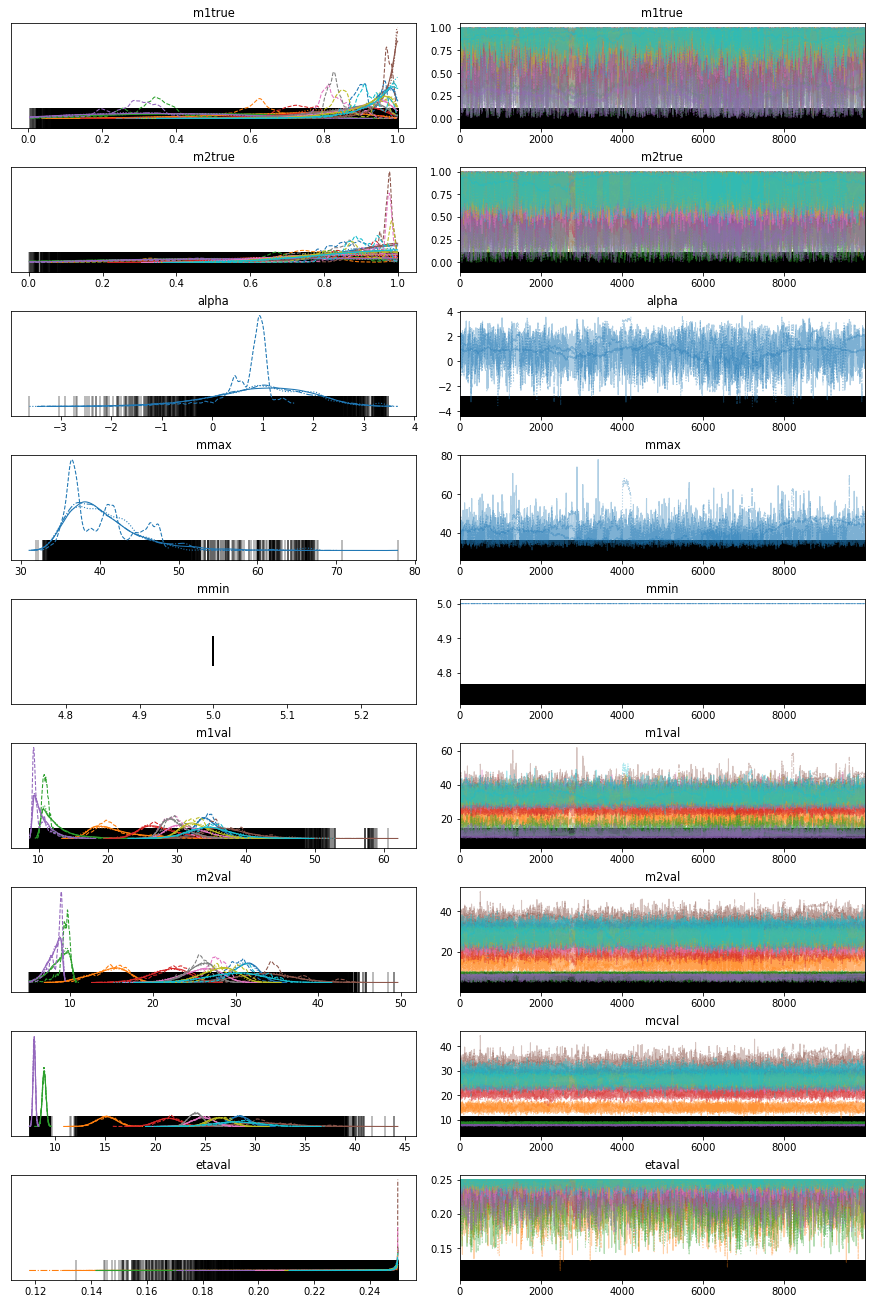

In [6]:
# 2) Obtain the posterior distribution for model A using pymc3. Compute also the posterior predictive 
#    distribution for m1 based on these results.

# We use the first model here.
#

with gwtc_astropop_modelA:
    # draw 10000 posterior samples
    trace = pm.sample(10000, return_inferencedata=False)
    
with gwtc_astropop_modelA:
    az.plot_trace(trace);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mmax, alpha, m2true, m1true]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 115 seconds.
There were 174 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 293 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1052 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6111150267196929, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/Users/jonathangair/opt/anaconda3/envs/imprs2021/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/Users/jo

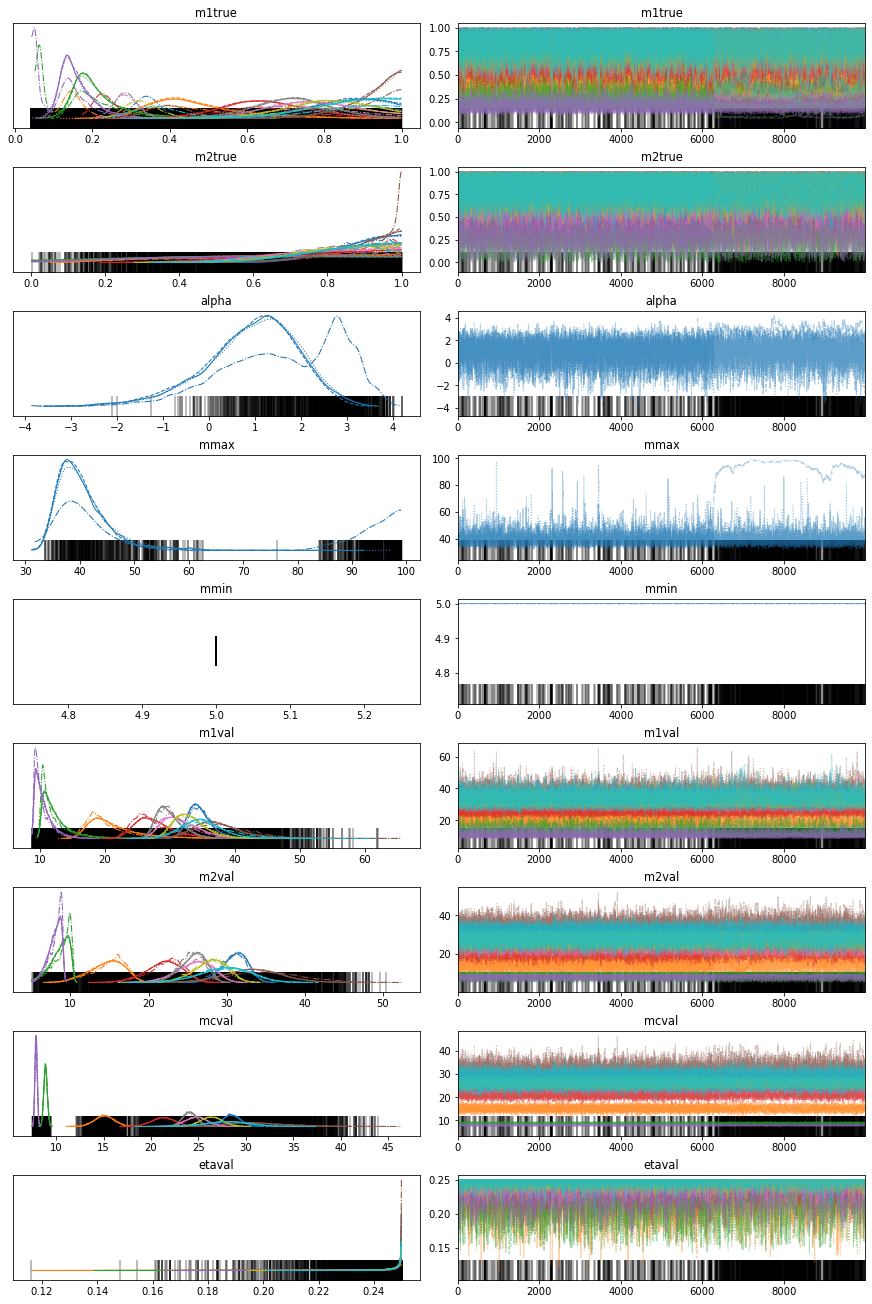

In [119]:
# We now repeat for the alternative specification of the model. The results should
# (and do) match.

with gwtc_astropop_modelA_Alt:
    # draw 1000 posterior samples
    trace_Alt = pm.sample(10000, return_inferencedata=False)
    
with gwtc_astropop_modelA_Alt:
    az.plot_trace(trace_Alt);

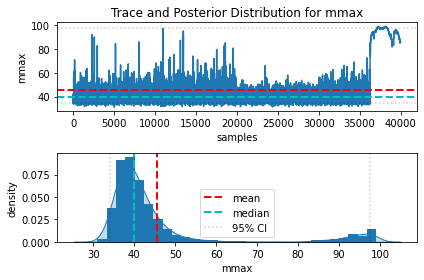

In [120]:
# Plot trace plot and histogram of posterior samples for parameter 'mmax'
param='mmax'
plotdata=trace[param]

cred_min, cred_max = np.percentile(plotdata, 2.5), np.percentile(plotdata, 97.5)
mean=np.mean(plotdata)
median=np.median(plotdata)

plt.subplot(2,1,1)
plt.plot(plotdata)
plt.xlabel('samples')
plt.ylabel(param)
plt.axhline(mean, color='r', lw=2, linestyle='--')
plt.axhline(median, color='c', lw=2, linestyle='--')
plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
plt.title('Trace and Posterior Distribution for {}'.format(param))

plt.subplot(2,1,2)
plt.hist(plotdata, 30, density=True); sns.kdeplot(plotdata, shade=True)
plt.xlabel(param)
plt.ylabel('density')
plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
plt.gcf().tight_layout()
plt.legend()



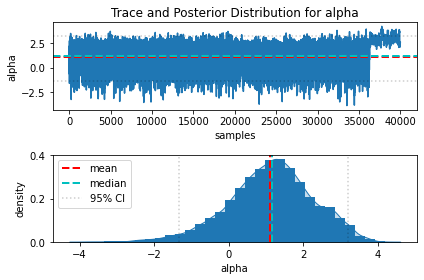

In [121]:
# Plot trace plot and histogram of posterior samples for parameter 'alpha'
param='alpha'
plotdata=trace[param]

cred_min, cred_max = np.percentile(plotdata, 2.5), np.percentile(plotdata, 97.5)
mean=np.mean(plotdata)
median=np.median(plotdata)

plt.subplot(2,1,1)
plt.plot(plotdata)
plt.xlabel('samples')
plt.ylabel(param)
plt.axhline(mean, color='r', lw=2, linestyle='--')
plt.axhline(median, color='c', lw=2, linestyle='--')
plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
plt.title('Trace and Posterior Distribution for {}'.format(param))

plt.subplot(2,1,2)
plt.hist(plotdata, 30, density=True); sns.kdeplot(plotdata, shade=True)
plt.xlabel(param)
plt.ylabel('density')
plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
plt.gcf().tight_layout()
plt.legend()




In [128]:
# 3) Adapt your model to fit model B from the GWTC-1 companion paper, in which all four parameters of the power
#    law are allowed to vary.
#
# To do this we will vary the first form of the model in which we relate the power-law 
# distribution to a uniform one.
#

gwtc_astropop_modelB = pm.Model()

with gwtc_astropop_modelB:

    # Priors for unknown model parameters
    m1u = pm.Uniform("m1u", lower=0, upper=1, shape=nobs)
    m2u = pm.Uniform("m2u", lower=0, upper=1, shape=nobs)
    alpha = pm.Uniform("alpha",lower=-4.0, upper=12.0)
    beta = pm.Uniform("beta",lower=-4.0, upper=12.0)
    mmax = pm.Uniform("mmax",lower=30.0, upper=100.0)
    mmin=pm.Uniform("mmin",lower=5.0, upper=10.0)
    
    
    m1val = pm.Deterministic("m1val",tt.exp(tt.log(m1u*tt.pow(mmax,1.0-alpha)+(1.0-m1u)*tt.pow(mmin,1.0-alpha))/(1.0-alpha)))
    m2val = pm.Deterministic("m2val",tt.exp(tt.log(m2u*tt.pow(m1val,1.0+beta)+(1.0-m2u)*tt.pow(mmin,1.0+beta))/(1.0+beta)))
    
    mcval = pm.Deterministic("mcval",tt.exp(0.6*tt.log(m1val*m2val))/tt.exp(0.2*tt.log(m1val+m2val)))
    etaval = pm.Deterministic("etaval",m1val*m2val/((m1val+m2val)*(m1val+m2val)))
    
    mcobs = pm.Normal("mcobs", mu=mc_mean, sigma=mc_std, observed=mcval)
    etaobs = pm.Beta("etaobs", alpha=eta_a, beta = 1, observed=4.*etaval)
    
    pm.Potential("seleff",-1.0*nobs*(tt.log((1.0-alpha)*(tt.pow(mmax,(3.2-alpha))-tt.pow(mmin,(3.2-alpha)))/((3.2-alpha)*(tt.pow(mmax,(1.0-alpha))-tt.pow(mmin,(1.0-alpha)))))))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [mmin, mmax, beta, alpha, m2u, m1u]


Sampling 8 chains for 1_000 tune and 10_000 draw iterations (8_000 + 80_000 draws total) took 327 seconds.
There were 2525 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6902543513107963, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3439 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6159031816464038, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2054 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1987 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.712535708725114, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2696 divergences after tuning. Increase `target_accept` or reparameterize.
The acce

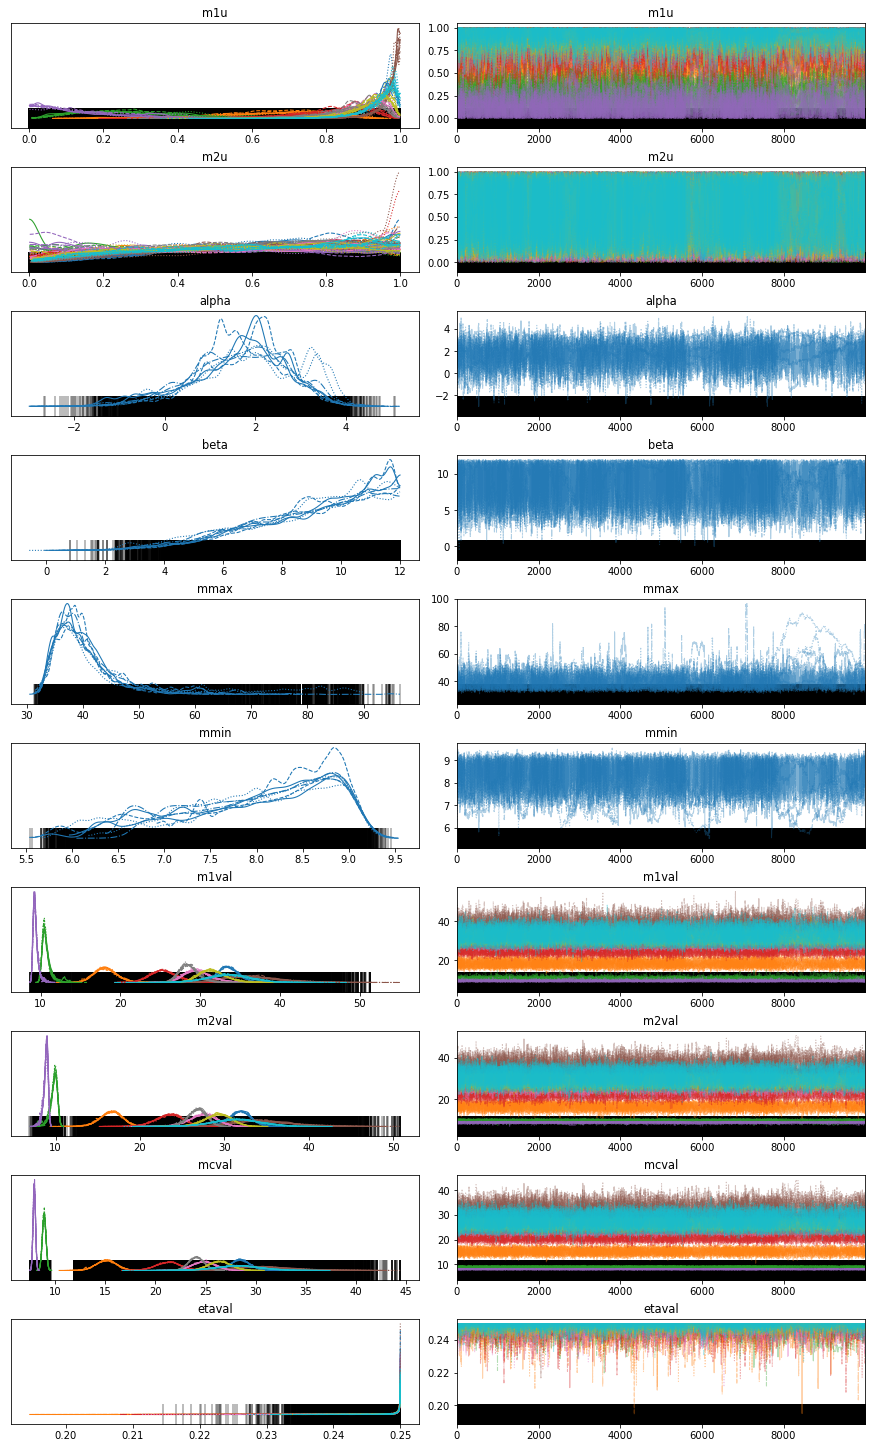

In [129]:
with gwtc_astropop_modelB:
    # draw 10000 posterior samples
    gwtc_astropop_modelB_trace = pm.sample(10000, chains=8, return_inferencedata=False)

with gwtc_astropop_modelB:
    az.plot_trace(gwtc_astropop_modelB_trace);

In [131]:
gwtc_astropop_modelB_trace=gwtc_astropop_modelB_NUTS_trace

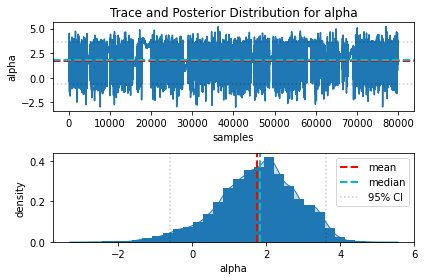

In [132]:
# Plot trace plot and histogram of posterior samples for parameter 'param'
param='alpha'
plotsamps=gwtc_astropop_modelB_trace[param]

cred_min, cred_max = np.percentile(plotsamps, 2.5), np.percentile(plotsamps, 97.5)
mean=np.mean(plotsamps)
median=np.median(plotsamps)

plt.subplot(2,1,1)
plt.plot(plotsamps)
plt.xlabel('samples')
plt.ylabel(param)
plt.axhline(mean, color='r', lw=2, linestyle='--')
plt.axhline(median, color='c', lw=2, linestyle='--')
plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
plt.title('Trace and Posterior Distribution for {}'.format(param))

plt.subplot(2,1,2)
plt.hist(plotsamps, 30, density=True); sns.kdeplot(plotsamps, shade=True)
plt.xlabel(param)
plt.ylabel('density')
plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
plt.gcf().tight_layout()
plt.legend()

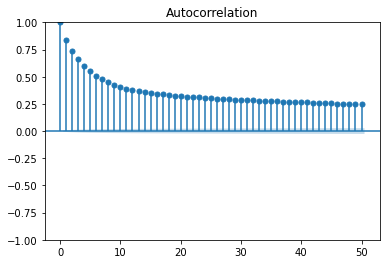

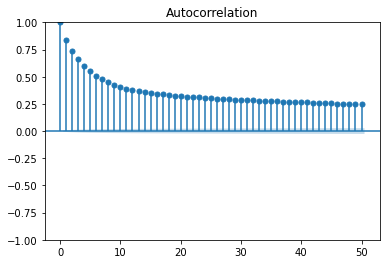

In [133]:
# Check that these samples are indeed good samples from the posterior by computing the auto-correlation function.
plot_acf(plotsamps)

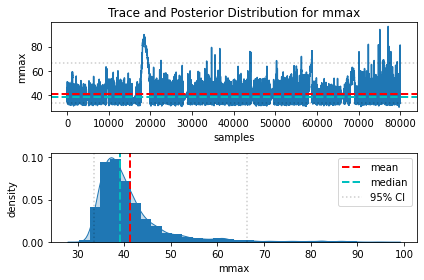

In [134]:
param='mmax'
plotsamps=gwtc_astropop_modelB_trace[param]

cred_min, cred_max = np.percentile(plotsamps, 2.5), np.percentile(plotsamps, 97.5)
mean=np.mean(plotsamps)
median=np.median(plotsamps)

plt.subplot(2,1,1)
plt.plot(plotsamps)
plt.xlabel('samples')
plt.ylabel(param)
plt.axhline(mean, color='r', lw=2, linestyle='--')
plt.axhline(median, color='c', lw=2, linestyle='--')
plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
plt.title('Trace and Posterior Distribution for {}'.format(param))

plt.subplot(2,1,2)
plt.hist(plotsamps, 30, density=True); sns.kdeplot(plotsamps, shade=True)
plt.xlabel(param)
plt.ylabel('density')
plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
plt.gcf().tight_layout()
plt.legend()

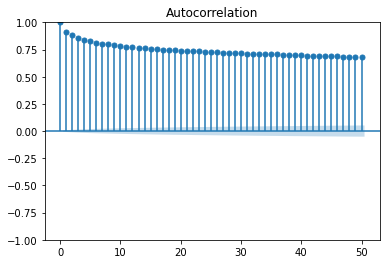

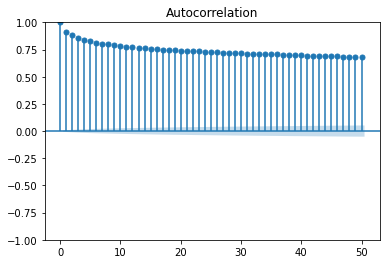

In [135]:
# Same check of samples
plot_acf(plotsamps)

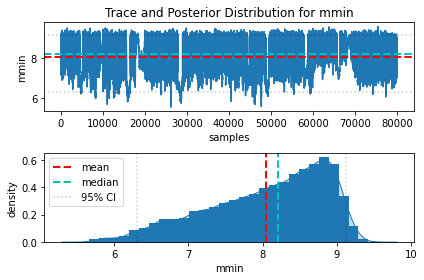

In [136]:
param='mmin'
plotsamps=gwtc_astropop_modelB_trace[param]

cred_min, cred_max = np.percentile(plotsamps, 2.5), np.percentile(plotsamps, 97.5)
mean=np.mean(plotsamps)
median=np.median(plotsamps)

plt.subplot(2,1,1)
plt.plot(plotsamps)
plt.xlabel('samples')
plt.ylabel(param)
plt.axhline(mean, color='r', lw=2, linestyle='--')
plt.axhline(median, color='c', lw=2, linestyle='--')
plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
plt.title('Trace and Posterior Distribution for {}'.format(param))

plt.subplot(2,1,2)
plt.hist(plotsamps, 30, density=True); sns.kdeplot(plotsamps, shade=True)
plt.xlabel(param)
plt.ylabel('density')
plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
plt.gcf().tight_layout()
plt.legend()

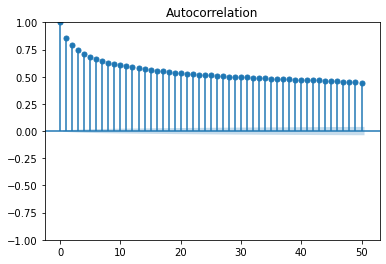

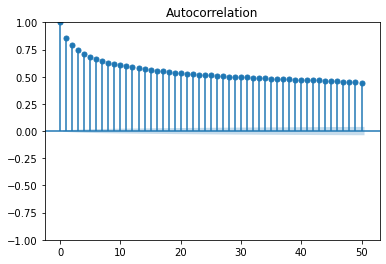

In [137]:
# Same check of samples
plot_acf(plotsamps)

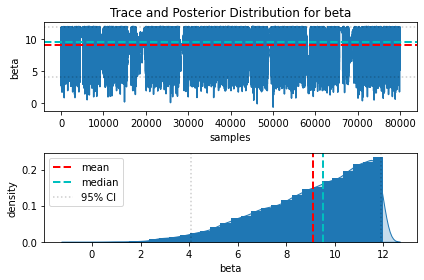

In [138]:
param='beta'
plotsamps=gwtc_astropop_modelB_trace[param]

cred_min, cred_max = np.percentile(plotsamps, 2.5), np.percentile(plotsamps, 97.5)
mean=np.mean(plotsamps)
median=np.median(plotsamps)

plt.subplot(2,1,1)
plt.plot(plotsamps)
plt.xlabel('samples')
plt.ylabel(param)
plt.axhline(mean, color='r', lw=2, linestyle='--')
plt.axhline(median, color='c', lw=2, linestyle='--')
plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
plt.title('Trace and Posterior Distribution for {}'.format(param))

plt.subplot(2,1,2)
plt.hist(plotsamps, 30, density=True); sns.kdeplot(plotsamps, shade=True)
plt.xlabel(param)
plt.ylabel('density')
plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
plt.gcf().tight_layout()
plt.legend()

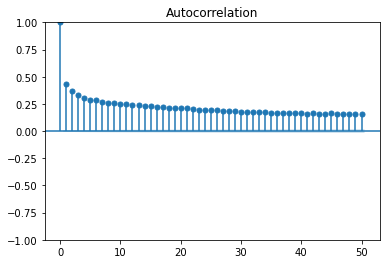

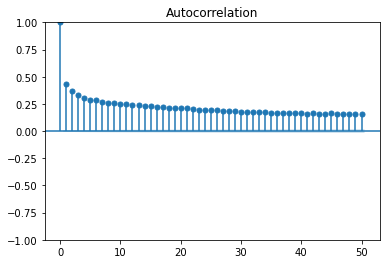

In [139]:
# Same check of samples
plot_acf(plotsamps)

We see that we favour beta at the upper end of the prior range, but measure alpha to be about 1.5, mmin to be approximately 9 and mmax to be approximately 35. These results are reasonably consistent with what was found using the actual LIGO observations. The LIGO posterior for beta was not quite the same as the one we get here, since while it did rise toward beta = 12, it flattened and was approximately flat between beta = 6 and beta = 12. Nonetheless, since this entire analysis was done using quantities eyeballed from the LIGO papers, the agreement is remarkably good.

In [210]:
# 4) How would you need to change the model to fit model C from the GWTC-1 companion paper, which includes both
#    a power law and a Gaussian component?

# There are several changes that need to be made. Firstly we need to specify exactly what
# the power-law plus peak model is. We do this by replacing the power-law piece of the mass 
# function by a sum of a power law and a Gaussian. This introduces three additional parameters -
# a mean and variance (or precision) for the Gaussian component, plus a mixing parameter that
# gives the weight of the power-law piece of the model. We apply this combination to the
# primary component mass part of the power law, and leave the m2 part unchanged, and still normalised
# such that the integral over m2 yields the target power-law + Gaussian distribution.
#
# The model thus takes the form
#
# p(m1, m2 | mmin, mmax, alpha, beta, zeta, mu, tau) = C(m1) (m2/m1)^beta
#                                 [ zeta * D(mmin, mmax, alpha) m1^(-alpha) Theta(mmax-m1)
#                                      + (1-zeta) * E(mu,tau,mmin) * exp(-tau*(m1-mu)^2/2) ]
#                                                          for mmin <= m2 <= m1 
#
# Note that the Gaussian term is not restricted to cut off at mmax, but the power-law piece
# is. The factor D(mmin, mmax, alpha) = (alpha-1)/(mmin^(-alpha+1)-mmax^(-alpha+1))
# ensures the power law term is normalised, while 
#      E(mu,tau,mmin) = sqrt(2.0*tau/pi)/(1-Erf[(mmin-mu)*sqrt(tau/2)])
#              does the same for the Gaussian component.
#
# The other thing that needs to be recomputed is the selection function, which we have
# approximated as the integral of m1^2.2 over the population model. The contribution from
# the power law term can be directly computed as before, but the Gaussian component
# cannot be. In practice the selection function will be estimated by using injections and
# so it would be known numerically. This can be incorporated in pymc3 by defining a 
# function that reweights the injection points and computes the selection probability
# for input values of the model parameters. For the sake of this example we will just
# approximate the selection function using the same function as before.
#
# A model of the above form can be implemented in the "alternative" way described in the
# answer to Q (i). The more complex density can be included by modifying the argument of the
# pm.Potential() function. This function just adds the argument to the target log-posterior 
# density.
#
# There is also an alternative way we can sample form this model, which is more efficient
# in pyMC3. The above population model can be thought of as a mixture of two populations.
# One population is described by the truncated power law, and the other population by the
# (truncated) Gaussian component. The mixing parameter, zeta, is the probability that any
# given event comes from the power-law population. To sample from such a mixture population
# we can introduce some additional variables, p_i, defined such that p_i = 1 for events 
# drawn from the power-law population and p_i = 0 for events drawn from the Gaussian.
# The prior for these p_i's is that they are independent draws from a Bernoulli 
# distribution with parameter zeta. If we specify that m1 = p_i m1_pl + (1-p_i) m1_G, 
# where m1_pl and m1_G are independent draws from the power-law and Gaussian modes,
# respectively, then m1 follows the target distribution. Since the distributions for
# m1_pl and m1_G are known distributions in pyMC3, the model definition is both easier
# and sampling is more efficient.
#
# Here is a pyMC3 definition of this model. Changes to the previous model are indicated
# with comments. 



gwtc_astropop_modelC = pm.Model()

with gwtc_astropop_modelC:

    # Rename this variable since it is associated with the power law component, not the
    # Gaussian.
    m1plu = pm.Uniform("m1plu", lower=0, upper=1, shape=nobs)
    m2u = pm.Uniform("m2u", lower=0, upper=1, shape=nobs)
    alpha = pm.Uniform("alpha",lower=-4.0, upper=12.0)
    beta = pm.Uniform("beta",lower=-4.0, upper=12.0)
    mmax = pm.Uniform("mmax",lower=30.0, upper=100.0)
    mmin=pm.Uniform("mmin",lower=5.0, upper=10.0)
    
    # Add priors for new parameters - the mixing fraction, the mean and standard deviation
    # of the Gaussian componnent, and the labels indicating if the source is drawn from 
    # the Gaussian or power law populations.
    zeta=pm.Uniform("zeta",lower=0.0,upper=1.0)
    mu=pm.Uniform("mu",lower=20.0,upper=50.0)
    sigG=pm.Uniform("sigG",lower=1.0,upper=10.0)
    p = pm.Bernoulli("p",p=zeta,shape=nobs)
    
    # Change how m1 is defined. We draw two differet masses and then combine them using
    # the population flag.
    m1G = pm.TruncatedNormal("m1G",mu=mu,sigma=sigG,lower=mmin,shape=nobs)
    m1pl = pm.Deterministic("m1pl",tt.exp(tt.log(m1plu*tt.pow(mmax,1.0-alpha)+(1.0-m1plu)*tt.pow(mmin,1.0-alpha))/(1.0-alpha)))
    m1val = pm.Deterministic("m1val",p*m1pl+(1-p)*m1G)
    
    m2val = pm.Deterministic("m2val",tt.exp(tt.log(m2u*tt.pow(m1val,1.0+beta)+(1.0-m2u)*tt.pow(mmin,1.0+beta))/(1.0+beta)))

    mcval = pm.Deterministic("mcval",tt.exp(0.6*tt.log(m1val*m2val))/tt.exp(0.2*tt.log(m1val+m2val)))
    etaval = pm.Deterministic("etaval",m1val*m2val/((m1val+m2val)*(m1val+m2val)))
    
    mcobs = pm.Normal("mcobs", mu=mc_mean, sigma=mc_std, observed=mcval)
    etaobs = pm.Beta("etaobs", alpha=eta_a, beta = 1, observed=4.0*etaval)

    # This term should also be changed in principle, as the selection function depends 
    # on the population model. As stated above, we will just use the same selection
    # fuction as before, as anything else would be too complicated to implement for
    # this toy implementation.
    
    pm.Potential("seleff",-1.0*nobs*(tt.log((1.0-alpha)*(tt.pow(mmax,(3.2-alpha))-tt.pow(mmin,(3.2-alpha)))/((3.2-alpha)*(tt.pow(mmax,(1.0-alpha))-tt.pow(mmin,(1.0-alpha)))))))

Multiprocess sampling (8 chains in 4 jobs)
CompoundStep
>NUTS: [m1G, sigG, mu, zeta, mmin, mmax, beta, alpha, m2u, m1plu]
>BinaryGibbsMetropolis: [p]


Sampling 8 chains for 1_000 tune and 10_000 draw iterations (8_000 + 80_000 draws total) took 283 seconds.
/Users/jonathangair/opt/anaconda3/envs/imprs2021/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 583 divergences after tuning. Increase `target_accept` or reparameterize.
There were 213 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9445907891238532, but should be close to 0.8. Try to increase the number of tuning steps.
There were 283 divergences after tuning. Increase `target_accept` or reparameterize.
There were 641 divergences after tuning. Increase `target_accept` or reparameterize.
There were 895 divergences after tuning. Increase `target_accept` or reparameterize.
There were 88 divergences after tuning. Increase `target_accep

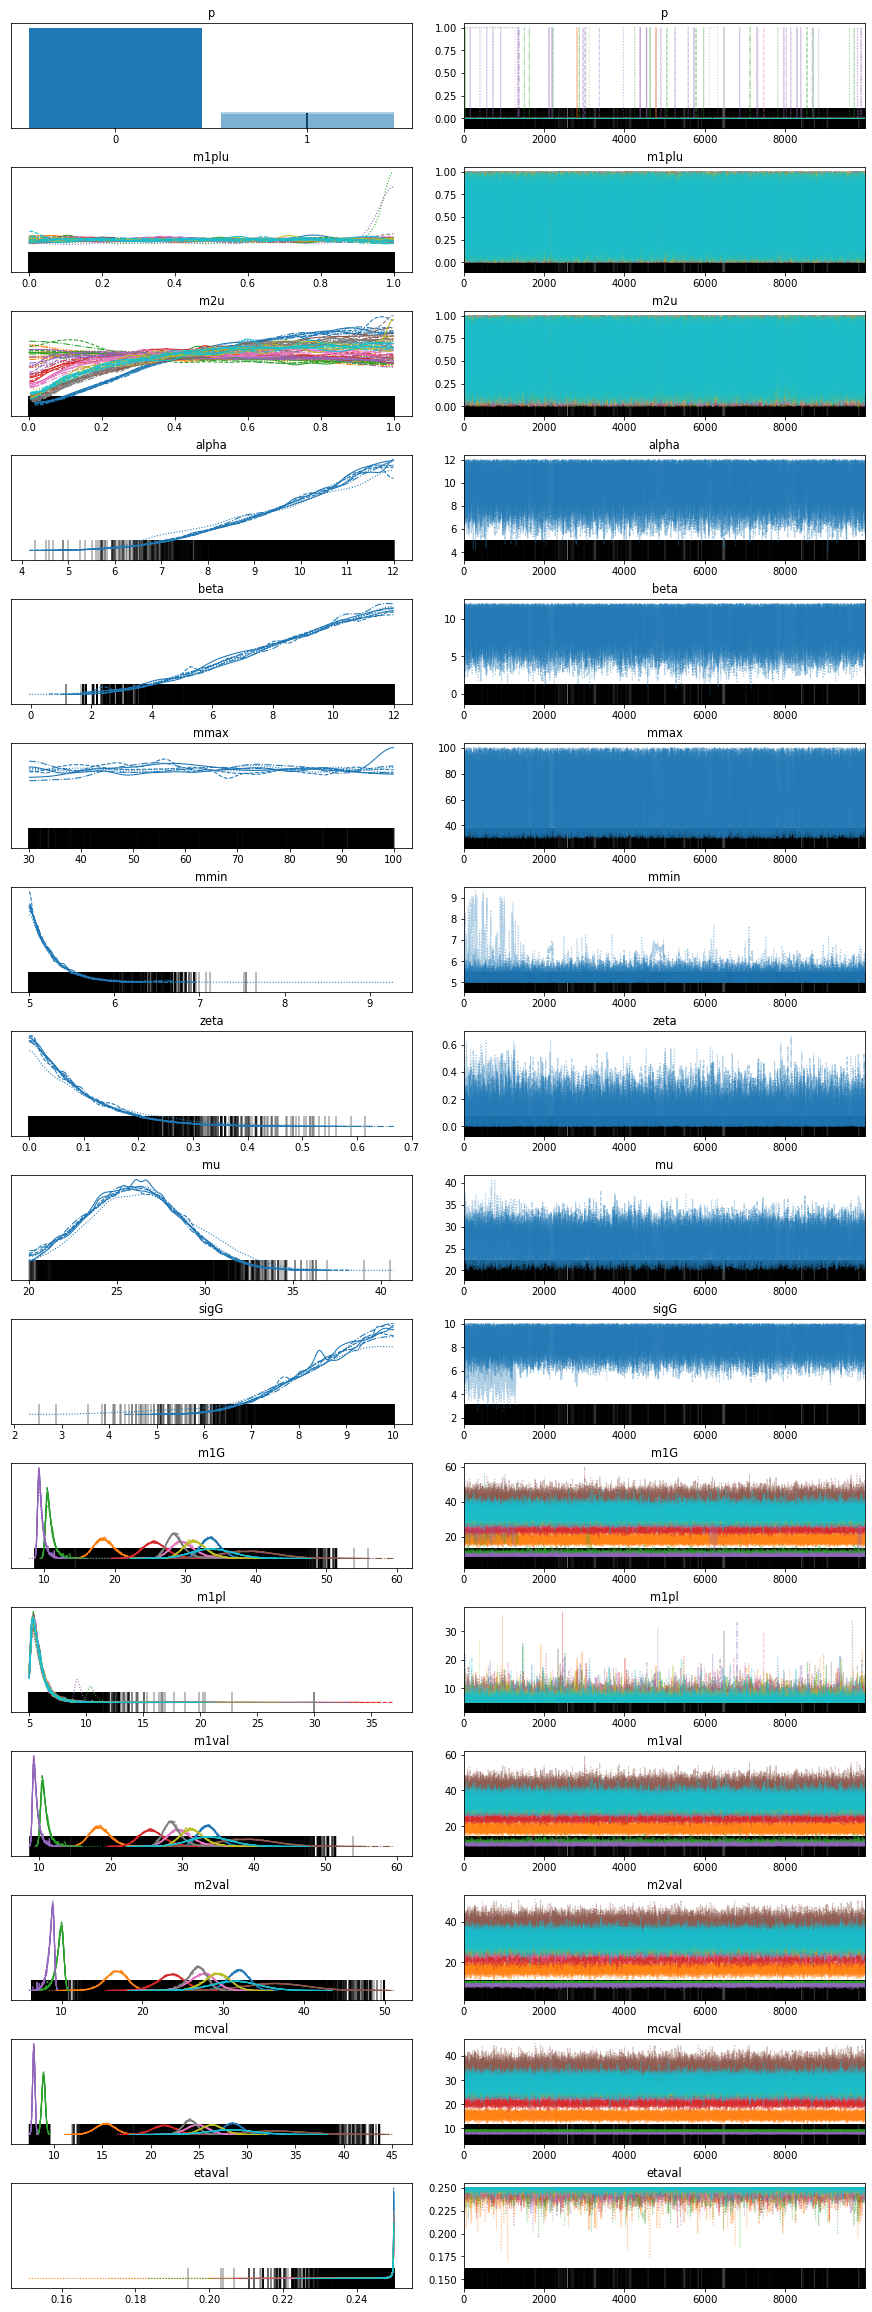

In [211]:
# We try sampling from this to see what happens.

# Set seed for reproducibility
np.random.seed(31415)

with gwtc_astropop_modelC:
    # draw 10000 posterior samples
    gwtc_astropop_modelC_trace = pm.sample(10000, chains=8, return_inferencedata=False)

with gwtc_astropop_modelC:
    az.plot_trace(gwtc_astropop_modelC_trace);

In [ ]:
# The results are not great, with no clear slope for the power law. However, we note 
# that the width of the Gaussian mode is being pushed toward the upper end of the prior 
# range, which means the distribution is very broad. So, what is happening is that the 
# Gaussian component is trying to fit the power law component, and hence the two modes 
# are degenerate. The LVK analysis found something similar. The shape of the posteriors
# were somewhat different in the LVK analysis, but the conclusion that the model is hard
# to fit is consistent. Given that we have not included selection effects properly, we 
# have ignored the smooth truncation of the power law at m_min and we have approximated
# the individual event posteriors by simple functions, we would not have expected to 
# get exactly the same thing.
#
# The fitting might be improved by adding the low-mass tapering, using more restrictive 
# priors on the parameters of the model or by runing the MCMC for longer. Try playing 
# around with the settings to see if you can improve the performance!

In [219]:
# As a final comment, one additional advantage of this approach is that the sampling also
# returns a posterior on p for each event, i.e., the probabilty that the source is a member
# of the power-law population.
#
# We can calculate the probabilty as the fraction of samples in the posterior for which
# p = 1. We do this as follows:

eventID=5
sum(gwtc_astropop_modelC_trace['p'][:,eventID-1])/len(gwtc_astropop_modelC_trace['p'][:,eventID-1])

# For most events the probabilty is zero, i.e., the event is definitely part of the 
# Gaussian component. This is an artefact of the fit degeneracy - the Gaussian is attempting
# to fit the whole population.
#
# The only two events that have non-zero probabilities of being in the power-law component are 
# event 3 (probability = 0.018) and event 5 (probability = 0.021). These are the two 
# lowest mass events, GW151226 ad GW170608. So, what is happening is that the Gaussian 
# is fitting the bulk of the population, at higher masses, and the very steep power-law 
# favoured by the model is trying to accommodate the lowest mass events which don't 
# fit as well with a single Gaussian truncated at the lower end.

0.0207625